In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


import os
print(os.listdir("."))

['.git', '.gitignore', '.ipynb_checkpoints', 'lgbm_regressor.pickle', 'NYC.ipynb', 'README.md', 'requirements.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


In [62]:
%%time

train = pd.read_csv('train.csv', nrows=2_000_000)
test = pd.read_csv('test.csv')

Wall time: 4.87 s


In [3]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [63]:
train.shape, test.shape

((2000000, 8), (9914, 7))

In [6]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [64]:
train.isnull().sum().sort_values(ascending=False)

dropoff_latitude     14
dropoff_longitude    14
passenger_count       0
pickup_latitude       0
pickup_longitude      0
pickup_datetime       0
fare_amount           0
key                   0
dtype: int64

In [65]:
test.isnull().sum().sort_values(ascending=False)

passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
key                  0
dtype: int64

In [66]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train)
add_travel_vector_features(test)

In [67]:
print(f'Old size: {len(train)}')
train.dropna(how='any', axis='rows', inplace=True)
print(f'New size: {len(train)}')

Old size: 2000000
New size: 1999986


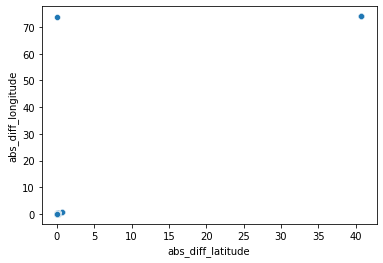

In [11]:
sns.scatterplot(x='abs_diff_latitude', y='abs_diff_longitude', data=train[:4000]);

In [68]:
print(f'Old size: {len(train)}')
train = train[(train['abs_diff_latitude'] < 5.0) & (train['abs_diff_longitude'] < 5.0)]
print(f'New size: {len(train)}')

Old size: 1999986
New size: 1995956


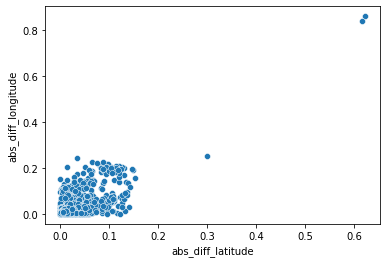

In [13]:
sns.scatterplot(x='abs_diff_latitude', y='abs_diff_longitude', data=train[:4000]);

In [14]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754


In [69]:
from collections import Counter
Counter(train['fare_amount'] < 0)

Counter({False: 1995883, True: 73})

In [70]:
print(f'Old size: {train.shape}')
train = train[train['fare_amount'] > 0]
print(f'New size: {train.shape}')

Old size: (1995956, 10)
New size: (1995837, 10)


In [17]:
train['passenger_count'].describe()

count    997965.000000
mean          1.684961
std           1.323832
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

In [71]:
train[train['passenger_count'] > 6]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
929022,2009-07-30 11:54:00.000000193,3.3,2009-07-30 11:54:00 UTC,0.00000,0.00000,0.00000,0.00000,208,0.0000,0.00000
1007609,2014-06-24 15:13:00.00000040,104.0,2014-06-24 15:13:00 UTC,-74.01578,40.71542,-74.17028,40.70834,9,0.1545,0.00708


In [72]:
print(f'Old size: {train.shape}')
train.drop(train[train['passenger_count'] > 6].index, axis = 0, inplace=True)
print(f'New size: {train.shape}')

Old size: (1995837, 10)
New size: (1995835, 10)


In [20]:
train['passenger_count'].value_counts()

1    689929
2    147847
5     70489
3     43680
4     21368
6     21124
0      3527
Name: passenger_count, dtype: int64

In [73]:
train[train['passenger_count']==0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
314,2015-06-02 23:16:15.00000012,34.0,2015-06-02 23:16:15 UTC,-73.974899,40.751095,-73.908546,40.881878,0,0.066353,0.130783
566,2012-01-28 21:33:18.0000002,4.9,2012-01-28 21:33:18 UTC,-73.955322,40.782840,-73.955797,40.773673,0,0.000475,0.009167
678,2012-02-27 07:24:20.0000003,6.5,2012-02-27 07:24:20 UTC,-73.983397,40.738183,-73.971395,40.758023,0,0.012002,0.019840
1160,2011-05-25 23:58:48.0000001,13.3,2011-05-25 23:58:48 UTC,-73.998360,40.740348,-73.946455,40.777348,0,0.051905,0.037000
1935,2011-10-23 11:09:28.0000001,10.1,2011-10-23 11:09:28 UTC,-73.971400,40.795000,-73.967900,40.768600,0,0.003500,0.026400
...,...,...,...,...,...,...,...,...,...,...
1998613,2011-05-22 14:21:14.0000002,7.7,2011-05-22 14:21:14 UTC,-73.999663,40.745835,-74.008447,40.719852,0,0.008784,0.025983
1999031,2012-01-21 19:09:31.0000003,8.9,2012-01-21 19:09:31 UTC,-74.002133,40.729500,-73.971997,40.751440,0,0.030136,0.021940
1999439,2011-12-04 11:09:57.0000001,15.3,2011-12-04 11:09:57 UTC,-73.954200,40.770300,-74.008100,40.738900,0,0.053900,0.031400
1999715,2011-10-21 13:47:07.0000002,13.3,2011-10-21 13:47:07 UTC,-73.988500,40.737600,-73.949200,40.778500,0,0.039300,0.040900


In [74]:
print(f'Old size: {train.shape}')
train.drop(train[train['passenger_count']==0].index, axis = 0, inplace=True)
print(f'New size: {train.shape}')

Old size: (1995835, 10)
New size: (1988786, 10)


In [75]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train.dtypes

key                                object
fare_amount                       float64
pickup_datetime       datetime64[ns, UTC]
pickup_longitude                  float64
pickup_latitude                   float64
dropoff_longitude                 float64
dropoff_latitude                  float64
passenger_count                     int64
abs_diff_longitude                float64
abs_diff_latitude                 float64
dtype: object

In [76]:
print(f"Old size {test.shape}")
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])
print(f"New size {test.shape}")
test.dtypes

Old size (9914, 9)
New size (9914, 9)


key                                object
pickup_datetime       datetime64[ns, UTC]
pickup_longitude                  float64
pickup_latitude                   float64
dropoff_longitude                 float64
dropoff_latitude                  float64
passenger_count                     int64
abs_diff_longitude                float64
abs_diff_latitude                 float64
dtype: object

In [78]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348


In [79]:
print(f"Old size {test.shape}")
data = [train, test]

for x in data:
    x["year"] = x["pickup_datetime"].dt.year
    x["month"] = x["pickup_datetime"].dt.month
    x["day_of_month"] = x["pickup_datetime"].dt.day
    x["day_of_week"] = x["pickup_datetime"].dt.dayofweek
    x["hour"] = x["pickup_datetime"].dt.hour

print(f"New size {test.shape}")


Old size (9914, 9)
New size (9914, 14)


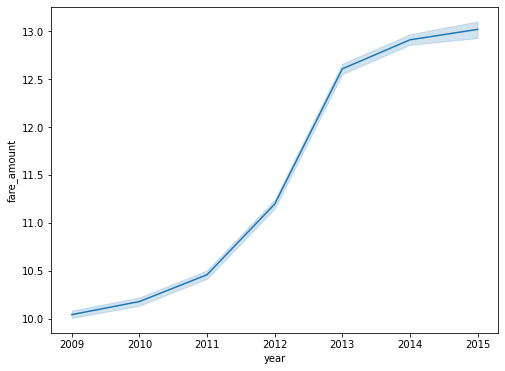

In [60]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='year', y='fare_amount', data=train);

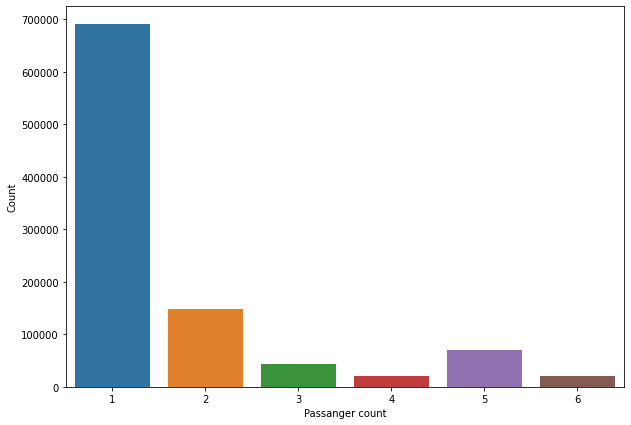

In [61]:
plt.figure(figsize=(10,7))
sns.countplot(x=train['passenger_count']);
plt.xlabel('Passanger count')
plt.ylabel('Count')
plt.show()

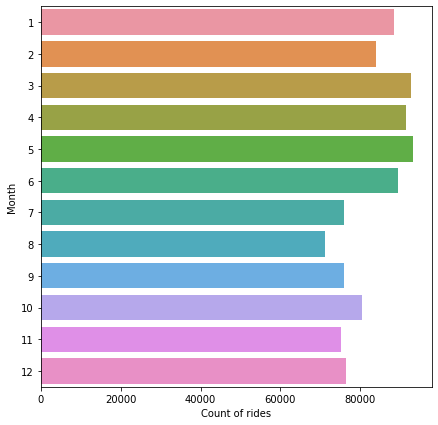

In [62]:
plt.figure(figsize=(7,7))
sns.countplot(y=train['month']);
plt.xlabel('Count of rides')
plt.ylabel('Month')
plt.show()

In [80]:
def get_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371

        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])

        delta_phi = np.radians(i[lat2] - i[lat1])
        delta_lambda = np.radians(i[long2] - i[long2])

        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2

        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        d = (R * c)
        i['distance_km'] = d

    return d 

In [29]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'abs_diff_longitude', 'abs_diff_latitude', 'year',
       'month', 'day_of_month', 'day_of_week', 'hour'],
      dtype='object')

In [81]:
print(f"Old size {test.shape}")
get_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
print(f"New size {test.shape}")


Old size (9914, 14)
New size (9914, 15)


In [82]:
train[(train['pickup_latitude'] == 0) & (train['pickup_longitude'] == 0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,year,month,day_of_month,day_of_week,hour,distance_km
11,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00+00:00,0.0,0.0,0.0,0.0,3,0.0,0.0,2012,12,24,0,11,0.0
15,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00+00:00,0.0,0.0,0.0,0.0,1,0.0,0.0,2013,11,23,5,12,0.0
26,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00+00:00,0.0,0.0,0.0,0.0,1,0.0,0.0,2011,2,7,0,20,0.0
124,2013-01-17 17:22:00.00000043,8.0,2013-01-17 17:22:00+00:00,0.0,0.0,0.0,0.0,2,0.0,0.0,2013,1,17,3,17,0.0
192,2010-09-05 17:08:00.00000092,3.7,2010-09-05 17:08:00+00:00,0.0,0.0,0.0,0.0,5,0.0,0.0,2010,9,5,6,17,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999688,2011-08-04 07:17:00.00000075,2.5,2011-08-04 07:17:00+00:00,0.0,0.0,0.0,0.0,1,0.0,0.0,2011,8,4,3,7,0.0
1999705,2012-08-03 11:54:00.00000042,35.7,2012-08-03 11:54:00+00:00,0.0,0.0,0.0,0.0,1,0.0,0.0,2012,8,3,4,11,0.0
1999748,2012-07-30 23:55:00.00000073,5.7,2012-07-30 23:55:00+00:00,0.0,0.0,0.0,0.0,5,0.0,0.0,2012,7,30,0,23,0.0
1999852,2012-09-05 11:58:00.000000171,7.0,2012-09-05 11:58:00+00:00,0.0,0.0,0.0,0.0,2,0.0,0.0,2012,9,5,2,11,0.0


In [83]:
print(f"Old size {train.shape}")
train.drop(train[(train['pickup_latitude'] == 0) & (train['pickup_longitude'] == 0)].index, axis=0, inplace=True)
print(f"New size {train.shape}")

Old size (1988786, 16)
New size (1953015, 16)


# Fitting

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [10]:
print(lgbm.__version__)

3.1.1


In [35]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'abs_diff_longitude', \
            'abs_diff_latitude', 'year', 'month', 'day_of_month', 'day_of_week', 'hour', 'distance_km']

In [85]:
X = train[features]
y = train['fare_amount']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

### KNN

In [165]:
%%time

knn = KNeighborsRegressor(n_neighbors=400)
knn.fit(X_train, y_train)

Wall time: 30.2 s


KNeighborsRegressor(n_neighbors=400)

In [166]:
knn_pred = knn.predict(test[features])

### Random Forest

In [73]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=5)]
max_depth = [int(x) for x in np.linspace(start=20, stop=100, num=5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
max_features = ['auto', 'sqrt']

rf_params = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap,
            'max_features': max_features}
rf_params

{'n_estimators': [200, 400, 600, 800, 1000],
 'max_depth': [20, 40, 60, 80, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt']}

In [ ]:
%%time

rf = RandomForestRegressor()
rf_random_cv = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, \
                                  n_iter=50, cv=3, verbose=2, random_state=13, n_jobs=-1)
rf_random_cv.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [213]:
rf_pred_train = rf.predict(X_train[features])
rf_pred_test = rf.predict(X_test[features])

In [214]:
mean_squared_error(y_test, rf_pred_test, squared=False)

3.8271803526697266

In [215]:
mean_squared_error(y_train, rf_pred_train, squared=False)

1.4439217437319103

### Desicion Tree Regressor

In [41]:
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

dtr_params = {'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf}
dtr_params

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [42]:
%%time

dtr = DecisionTreeRegressor()
dtr_random_cv = RandomizedSearchCV(dtr, dtr_params, cv=5, n_iter=50, n_jobs=-1)
dtr_random_cv.fit(X_train, y_train)

Wall time: 35min 1s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]})

In [43]:
dtr_random_cv.best_params_

{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}

In [44]:
dtr_pred_train = dtr_random_cv.predict(X_train[features])
dtr_pred_test = dtr_random_cv.predict(X_test[features])

In [45]:
mean_squared_error(y_train, dtr_pred_train, squared=False)

4.0008016492579825

In [46]:
mean_squared_error(y_test, dtr_pred_test, squared=False)

4.517793879972861

### Light Gradient Boosting

In [87]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'seed':0,
        'force_col_wise': True
    }

In [88]:
%%time

train_set = lgbm.Dataset(X_train, y_train, silent=False)
test_set = lgbm.Dataset(X_test, y_test, silent=False)
model = lgbm.train(params, train_set, num_boost_round=10000, early_stopping_rounds=500, verbose_eval=500, valid_sets=test_set)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Total Bins 35091
[LightGBM] [Info] Number of data points in the train set: 1757713, number of used features: 13
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 11.343327
Training until validation scores don't improve for 500 rounds
[500]	valid_0's rmse: 3.6714
[1000]	valid_0's rmse: 3.62114
[1500]	valid_0's rmse: 3.59706
[2000]	valid_0's rmse: 3.58515
[2500]	valid_0's rmse: 3.57682
[3000]	valid_0's rmse: 3.57202
[3500]	valid_0's rmse: 3.57069
[4000]	valid_0's rmse: 3.56984
[4500]	valid_0's rmse: 3.56803
[5000]	valid_0's rmse: 3.56639
[5500]	valid_0's rmse: 3.56626
Early stopping, best iteration is:
[5267]	valid_0's rmse: 3.56511
Wall time:

In [89]:
pred_lgbm = np.zeros(test.shape[0])

In [94]:
pred_lgbm_test = model.predict(X_test[features], num_iteration=model.best_iteration)
pred_lgbm_train = model.predict(X_train[features], num_iteration=model.best_iteration)

In [95]:
mean_squared_error(y_test, pred_lgbm_test, squared=False)

3.565108790683872

In [96]:
mean_squared_error(y_train, pred_lgbm_train, squared=False)

2.8701247569569683

### Submit

In [91]:
submit = pd.DataFrame({
    "key": test.key,
    "fare_amount": pred_lgbm_submit.round(2)}, columns=['key', 'fare_amount'])
submit.to_csv('sample_submission.csv', index = False)

In [92]:
submit.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.36
1,2015-01-27 13:08:24.0000003,10.84
2,2011-10-08 11:53:44.0000002,4.28
3,2012-12-01 21:12:12.0000002,8.92
4,2012-12-01 21:12:12.0000003,15.37
5,2012-12-01 21:12:12.0000005,10.16
6,2011-10-06 12:10:20.0000001,5.49
7,2011-10-06 12:10:20.0000003,49.79
8,2011-10-06 12:10:20.0000002,11.02
9,2014-02-18 15:22:20.0000002,7.08


### Save the model

In [93]:
import pickle

pickle_out = open('lgbm_regressor.pickle', 'wb')
pickle.dump(model, pickle_out)

if os.path.getsize('lgbm_regressor.pickle') > 0:
    print('File is not empty')

File is not empty
